In [125]:
import string
import pandas as pd
import numpy as np
import requests
import re

from bs4 import BeautifulSoup

from nltk.tokenize import StanfordTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS




import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## read in the character list
master = pd.read_csv('Shakespeare_characters.txt', delimiter='\t', encoding='ISO-8859-1')
master.head()

,Speaker,Unnamed: 1,Gender,#Lines,Play,TopVillain,Fools
0,Hamlet,NaN,Male,1506,Hamlet,NaN,NaN
1,Iago,NaN,Male,1088,Othello,yes,NaN
2,King Henry,NaN,Male,1031,Henry V,NaN,NaN
3,Othello,NaN,Male,880,Othello,NaN,NaN
4,Timon,NaN,Male,850,Timon of Athens,NaN,NaN


In [3]:
master.tail()

,Speaker,Unnamed: 1,Gender,#Lines,Play,TopVillain,Fools
1528,First And Second Murderer,NaN,Male,1,Richard III,NaN,NaN
1529,All,NaN,Male,1,Richard III,NaN,NaN
1530,Ghost Of Grey,NaN,Male,1,Richard III,NaN,NaN
1531,Herbert,NaN,Male,1,Richard III,NaN,NaN
1532,Queen Elizabeth And Duchess Of York,NaN,Female,1,Richard III,NaN,NaN


In [4]:
home_url = 'http://shakespeare.mit.edu/index.html'
request = requests.get(home_url).content
main_soup = BeautifulSoup(request, 'html.parser')

In [5]:
play_hrefs = [a['href'] for a in main_soup.findAll('a', href=True) if 'index.html' in a['href']]

In [6]:
main_url = 'http://shakespeare.mit.edu/'

In [17]:
## still need to get rid of the stage direction
def get_char_text(href, play):
    
    new_url = 'http://shakespeare.mit.edu/' + href
    request = requests.get(new_url).content
    new_soup = BeautifulSoup(request, 'html.parser')
    
    act, scene = re.compile('\.(\d+)\.(\d+)\.html').findall(href)[0]

    characters = [b.text for b in new_soup.findAll('b')]
    quotes = [quote.text.split('\n') for quote in new_soup.findAll('blockquote')]
    quotes = quotes[1:]
    
    character_text = [i for i in zip(characters, quotes)]    
    
    dict_list = []
    for i in character_text:
        character = i[0]
        the_text = i[1]
        for j in the_text:
            dict_list.append({'play': play, 'act': act, 'scene': scene, 
                              'character': character, 'text': j})
    return(dict_list)

In [21]:
all_dicts = []
for play_href in play_hrefs:
    play = re.compile('(\w+)\/index.html').findall(play_href)[0]
    print(play)
    print(main_url + play_href)
    request = requests.get(main_url + play_href).content
    the_soup = BeautifulSoup(request, 'html.parser')
    inside_hrefs = [play + '/' + a['href'] for a in the_soup.findAll('a', href=True) if play in a['href']]
    temp_dicts = []
    for href in inside_hrefs:
        dict_list = get_char_text(href, play)
        for i in dict_list:
            temp_dicts.append(i)
    for the_dict in temp_dicts:
        all_dicts.append(the_dict)

allswell
http://shakespeare.mit.edu/allswell/index.html
asyoulikeit
http://shakespeare.mit.edu/asyoulikeit/index.html
comedy_errors
http://shakespeare.mit.edu/comedy_errors/index.html
cymbeline
http://shakespeare.mit.edu/cymbeline/index.html
lll
http://shakespeare.mit.edu/lll/index.html
measure
http://shakespeare.mit.edu/measure/index.html
merry_wives
http://shakespeare.mit.edu/merry_wives/index.html
merchant
http://shakespeare.mit.edu/merchant/index.html
midsummer
http://shakespeare.mit.edu/midsummer/index.html
much_ado
http://shakespeare.mit.edu/much_ado/index.html
pericles
http://shakespeare.mit.edu/pericles/index.html
taming_shrew
http://shakespeare.mit.edu/taming_shrew/index.html
tempest
http://shakespeare.mit.edu/tempest/index.html
troilus_cressida
http://shakespeare.mit.edu/troilus_cressida/index.html
twelfth_night
http://shakespeare.mit.edu/twelfth_night/index.html
two_gentlemen
http://shakespeare.mit.edu/two_gentlemen/index.html
winters_tale
http://shakespeare.mit.edu/winters_

In [22]:
text_df = pd.DataFrame(all_dicts)
blank_filter = text_df["text"] != ""
text_df = text_df[blank_filter]
text_df = text_df[['play', 'act','scene', 'character', 'text']]
text_df = text_df.sort_values(by=['act', 'scene'])
text_df.head()

,play,act,scene,character,text
81578,2henryiv,0,0,RUMOUR,"Enter RUMOUR, painted full of tongues"
49051,taming_shrew,0,1,SLY,"I'll pheeze you, in faith."
49054,taming_shrew,0,1,Hostess,"A pair of stocks, you rogue!"
49057,taming_shrew,0,1,SLY,Ye are a baggage: the Slys are no rogues; look in
49058,taming_shrew,0,1,SLY,the chronicles; we came in with Richard Conque...


In [23]:
text_df.tail()

,play,act,scene,character,text
63197,troilus_cressida,5,9,AGAMEMNON,March patiently along: let one be sent
63198,troilus_cressida,5,9,AGAMEMNON,To pray Achilles see us at our tent.
63199,troilus_cressida,5,9,AGAMEMNON,"If in his death the gods have us befriended,"
63200,troilus_cressida,5,9,AGAMEMNON,"Great Troy is ours, and our sharp wars are ended."
63201,troilus_cressida,5,9,AGAMEMNON,"Exeunt, marching"


In [24]:
text_df.shape

(113332, 5)

In [25]:
text_df['character'] = text_df.character.apply(lambda x: str.lower(x))
text_df['text'] = text_df.text.apply(lambda x: str.lower(x))

In [26]:
text_df.head()

,play,act,scene,character,text
81578,2henryiv,0,0,rumour,"enter rumour, painted full of tongues"
49051,taming_shrew,0,1,sly,"i'll pheeze you, in faith."
49054,taming_shrew,0,1,hostess,"a pair of stocks, you rogue!"
49057,taming_shrew,0,1,sly,ye are a baggage: the slys are no rogues; look in
49058,taming_shrew,0,1,sly,the chronicles; we came in with richard conque...


In [30]:
pd.to_pickle(text_df, 'text_df.pkl')

In [31]:
all_characters = list(set(text_df.character.values))

In [90]:
def get_all_text(character, scraped_df):
    character = scraped_df[scraped_df.character == character]
    character_text = character.text.values
    exclude_text = set(string.punctuation)
    character_text = [''.join(ch for ch in i if ch not in exclude) for i in character_text] ## removes punctuation
    wnl = WordNetLemmatizer()
    character_text = [wnl.lemmatize(j) for i in character_text for j in i.split()]
    character_text = [word for word in character_text if word not in stopwords.words('english')]
    character_text = " ".join( character_text )
    return(character_text)

In [91]:
prepped_dict = {}
for character in all_characters:
    prepped_dict[character] = get_all_text(character, text_df)

In [97]:
tfidf_vectorizer = TfidfVectorizer() ## should play around with parameters
%time tfidf_matrix = tfidf_vectorizer.fit_transform(prepped_dict.values()) #fit the vectorizer to synopses

CPU times: user 364 ms, sys: 6.38 ms, total: 370 ms
Wall time: 369 ms


In [98]:
tfidf_matrix.shape

(953, 24050)

In [113]:
terms = tfidf_vectorizer.get_feature_names()

In [102]:
num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 1min 2s, sys: 987 ms, total: 1min 3s
Wall time: 16.1 s


In [103]:
pd.to_pickle(km, 'km.pikl')

In [105]:
len(clusters)

953

In [108]:
len(all_characters)

953

In [109]:
cluster_dict = dict(zip(all_characters, clusters))

In [115]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d:" % i,)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind],)

Top terms per cluster:
Cluster 0:
 caesar
 antony
 brutus
 shall
 cassius
 thou
 well
 mark
 thy
 good
Cluster 1:
 shall
 come
 thou
 king
 good
 lord
 thy
 let
 wa
 well
Cluster 2:
 lord
 good
 sir
 come
 grace
 noble
 king
 please
 protector
 duke
Cluster 3:
 thou
 thy
 thee
 shall
 lord
 come
 love
 good
 would
 well
Cluster 4:
 sir
 master
 good
 come
 mistress
 john
 man
 thou
 would
 well


In [120]:
pd.DataFrame([cluster_dict]).transpose().head()

,0
& c,2
a lord,1
a patrician,1
a player,3
aaron,1


In [121]:
pd.DataFrame([cluster_dict]).transpose().tail()

,0
york,3
young clifford,3
young lucius,1
young marcius,3
young siward,1


In [122]:
#set up colors per clusters using a dict
cluster_colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow', 4: 'orange'}

#set up cluster names using a dict
cluster_names = {0: 'ceasar, antony, brutus', 
                 1: 'king, good, lord', 
                 2: 'grace, noble, protector', 
                 3: 'love, good, would', 
                 4: 'mistress, master, man'}

In [124]:
dist = 1 - cosine_similarity(tfidf_matrix)

In [126]:
MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

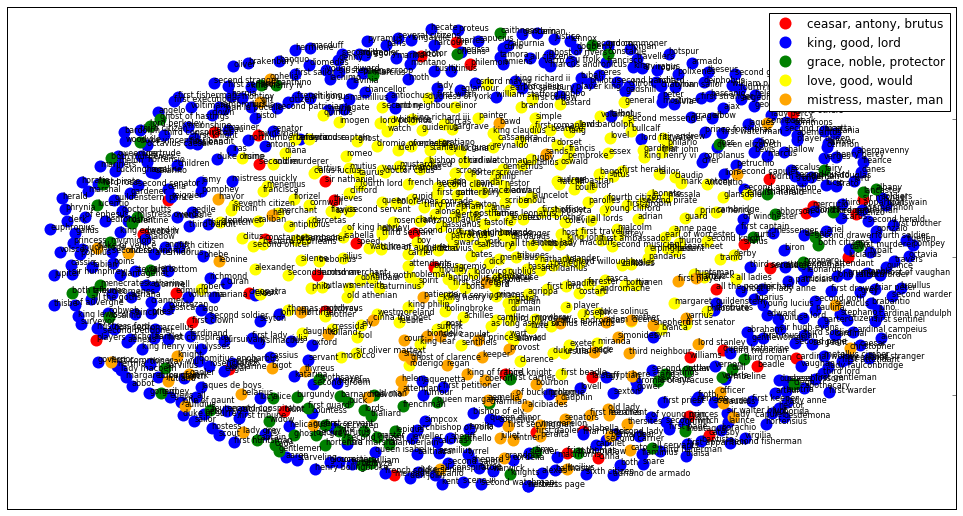

In [129]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, character=all_characters)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['character'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)